<a href="https://colab.research.google.com/github/beatrizjafelice/Student-Scores-Clustering/blob/master/Student_Scores_Clustering_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade
Realizar uma análise de presença de grupos em uma base de dados de seu interesse:
1. Escolha uma base de dados
2. Realize uma análise inicial
3. Realize a análise de agrupamento (investigando formas de pré-processamento)
 * Análise de número de grupos
 * Aplicação de algoritmos de agrupamento
4. Selecionar um dos resultados e realizar uma interpretação dos grupos utilizando, por exemplo:
 * No caso do k-means, interpretar os centróides
 * Função groupby do pandas com os grupos resultantes para observar suas características numéricas, como médias.
 * Ajustar uma árvore de decisão utilizando como classes os grupos resultantes.

No item 4 da atividade, no caso de utilização de reescala, os atributos originais devem ser restaurados, por exemplo:
* utilizando a base de dados original e adicionando os rótulos de grupo resultantes
* utilizando o método **inverse_transform** do *scaler*

## Carregando os dados

Para este estudo, será utilizado o dataset [Student Scores](https://www.kaggle.com/datasets/mexwell/student-scores?rvi=1), disponível no Kaggle.

**Metadados retirados da documentação:**

id: Identificador único atribuído a cada estudante (necessário porque é possível que dois ou mais estudantes tenham o mesmo nome).

first_name: O primeiro nome do estudante.

last_name: O sobrenome do estudante.

email: O endereço de e-mail do estudante.

gender: O gênero do estudante.

math_score: A nota obtida pelo estudante na disciplina de matemática (0 - 100).

history_score: Nota em história (0 - 100).

physics_score: Nota em física (0 - 100).

chemistry_score: Nota em química (0 - 100).

biology_score: Nota em biologia (0 - 100).

english_score: Nota em inglês (0 - 100).

geography_score: Nota em geografia (0 - 100).

part_time_job: Indica se o estudante trabalha em um emprego de meio período. Ter um emprego de meio período pode afetar as notas.

absence_days: O total de dias em que o estudante faltou à aula por vários motivos.

extracurricular_activities: Indica se o estudante participa de atividades extracurriculares. Isso pode incluir clubes, esportes, artes ou outras atividades fora do currículo acadêmico regular.

weekly_self_study_hours: Representa o número de horas na semana que o estudante dedica ao estudo individual. Indica a quantidade de tempo que o estudante dedica à aprendizagem e aos estudos fora da sala de aula.

career_aspiration: Esta coluna registra as aspirações profissionais ou metas futuras do estudante. Fornece insights sobre a profissão ou área que o estudante pretende seguir após concluir sua formação.

O objetivo dessa atividade é encontrar grupos de estudantes que compartilham um perfil semelhante de acordo com as características presentes no dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv('https://drive.google.com/u/3/uc?id=14WVEn-9jv3JXDspI12JFuIIOfHxYx0zu&export=download')
df.head()

,id,first_name,last_name,email,gender,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,career_aspiration,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,1,Paul,Casey,paul.casey.1@gslingacademy.com,male,False,3,False,27,Lawyer,73,81,93,97,63,80,87
1,2,Danielle,Sandoval,danielle.sandoval.2@gslingacademy.com,female,False,2,False,47,Doctor,90,86,96,100,90,88,90
2,3,Tina,Andrews,tina.andrews.3@gslingacademy.com,female,False,9,True,13,Government Officer,81,97,95,96,65,77,94
3,4,Tara,Clark,tara.clark.4@gslingacademy.com,female,False,5,False,3,Artist,71,74,88,80,89,63,86
4,5,Anthony,Campos,anthony.campos.5@gslingacademy.com,male,False,5,False,10,Unknown,84,77,65,65,80,74,76


## Análise Exploratória

In [ ]:
df.shape

(2000, 17)

In [ ]:
df.describe()

,id,absence_days,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,1000.500000,3.665500,17.755500,83.452000,80.332000,81.336500,79.995000,79.58150,81.277500,80.888000
std,577.494589,2.629271,12.129604,13.224906,12.736046,12.539453,12.777895,13.72219,12.027087,11.637705
min,1.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,30.00000,50.000000,60.000000
25%,500.750000,2.000000,5.000000,77.000000,69.750000,71.000000,69.000000,69.00000,72.000000,71.000000
50%,1000.500000,3.000000,18.000000,87.000000,82.000000,83.000000,81.000000,81.00000,83.000000,81.000000
75%,1500.250000,5.000000,28.000000,93.000000,91.000000,92.000000,91.000000,91.00000,91.000000,91.000000
max,2000.000000,10.000000,50.000000,100.000000,100.000000,100.000000,100.000000,100.00000,99.000000,100.000000


In [ ]:
df.columns

Index(['id', 'first_name', 'last_name', 'email', 'gender', 'part_time_job',
       'absence_days', 'extracurricular_activities', 'weekly_self_study_hours',
       'career_aspiration', 'math_score', 'history_score', 'physics_score',
       'chemistry_score', 'biology_score', 'english_score', 'geography_score'],
      dtype='object')

In [ ]:
df.career_aspiration.value_counts()

career_aspiration
Software Engineer        315
Business Owner           309
Unknown                  223
Banker                   169
Lawyer                   138
Accountant               126
Doctor                   119
Real Estate Developer     83
Stock Investor            73
Construction Engineer     68
Artist                    67
Game Developer            63
Government Officer        61
Teacher                   59
Designer                  56
Scientist                 39
Writer                    32
Name: count, dtype: int64

Verificando valores nulos:

In [ ]:
df.isnull().sum()

id                            0
first_name                    0
last_name                     0
email                         0
gender                        0
part_time_job                 0
absence_days                  0
extracurricular_activities    0
weekly_self_study_hours       0
career_aspiration             0
math_score                    0
history_score                 0
physics_score                 0
chemistry_score               0
biology_score                 0
english_score                 0
geography_score               0
dtype: int64

Verificando outliers:

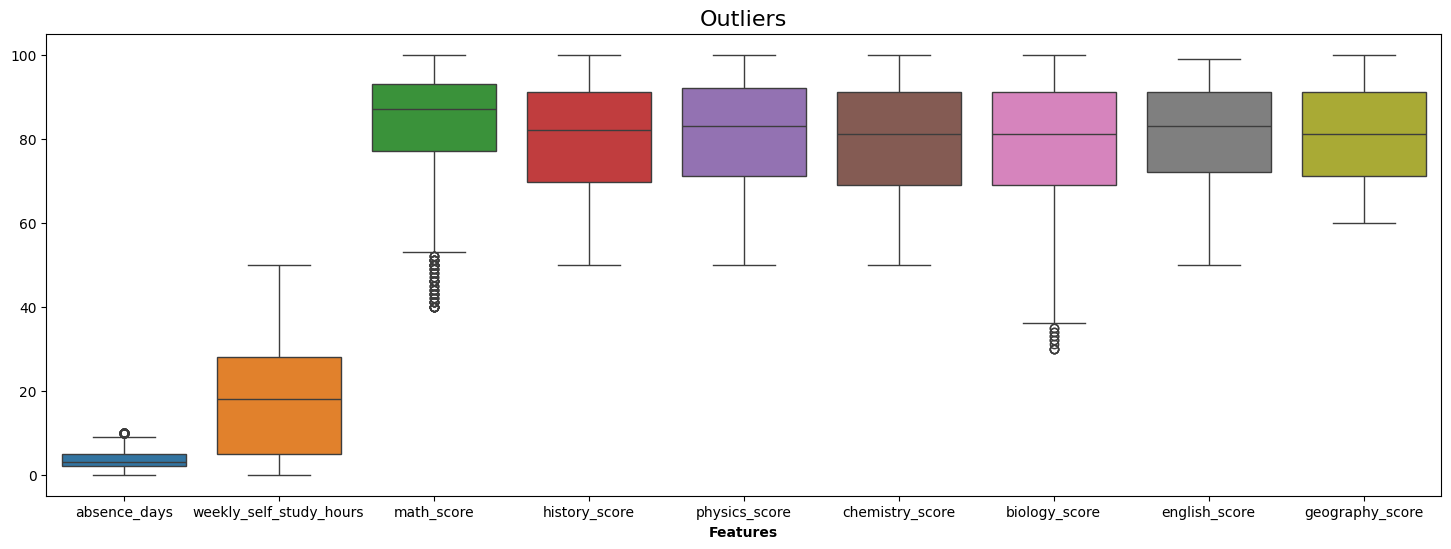

In [ ]:
def show_boxplot(df):
  plt.rcParams['figure.figsize'] = [18,6]
  sns.boxplot(data = df.drop(['id', 'part_time_job', 'extracurricular_activities'], axis=1), orient="v")
  plt.title("Outliers", fontsize = 16)
  plt.xlabel("Features", fontweight = 'bold')

show_boxplot(df)

Verifica-se a presença de outliers nas variáveis absence_days, math_score e biology_score. No entanto, para essa análise, esses valores não serão tratados, já que, nesse contexto, é comum encontrar valores dessa natureza (alunos com notas acima ou abaixo da média) e, portanto, essas informações podem auxiliar no processo de segmentação dos perfis de estudantes.

## Pré-processamento

Separando as features utilizadas para o agrupamento:

In [ ]:
df.columns

Index(['id', 'first_name', 'last_name', 'email', 'gender', 'part_time_job',
       'absence_days', 'extracurricular_activities', 'weekly_self_study_hours',
       'career_aspiration', 'math_score', 'history_score', 'physics_score',
       'chemistry_score', 'biology_score', 'english_score', 'geography_score'],
      dtype='object')

In [ ]:
features = df.drop(['id', 'first_name', 'last_name', 'gender', 'email', 'career_aspiration'], axis=1)
features.head()

,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,False,3,False,27,73,81,93,97,63,80,87
1,False,2,False,47,90,86,96,100,90,88,90
2,False,9,True,13,81,97,95,96,65,77,94
3,False,5,False,3,71,74,88,80,89,63,86
4,False,5,False,10,84,77,65,65,80,74,76


Aplicando transformações nas colunas categóricas:

In [ ]:
features['part_time_job'] = features['part_time_job'].astype(int)
features['extracurricular_activities'] = features['extracurricular_activities'].astype(int)
features.head()

,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,0,3,0,27,73,81,93,97,63,80,87
1,0,2,0,47,90,86,96,100,90,88,90
2,0,9,1,13,81,97,95,96,65,77,94
3,0,5,0,3,71,74,88,80,89,63,86
4,0,5,0,10,84,77,65,65,80,74,76


Verificando a simetria da base de dados:

In [ ]:
features.skew(numeric_only=True)

part_time_job                 1.876711
absence_days                  0.767021
extracurricular_activities    1.470199
weekly_self_study_hours       0.138065
math_score                   -1.090145
history_score                -0.269966
physics_score                -0.346301
chemistry_score              -0.201933
biology_score                -0.529917
english_score                -0.456268
geography_score              -0.097094
dtype: float64

Verifica-se que a maior parte das variáveis possui uma distribuição aproximadamente simétrica (skew próximo de 0), com exceção de variáveis binárias, o que é esperado.

Escalando a base de dados:

In [ ]:
scaler = StandardScaler()
features_norm = scaler.fit_transform(features)

In [ ]:
features_norm = pd.DataFrame(data=features_norm, columns=features.columns)
features_norm.head()

,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,-0.433184,-0.253175,-0.506242,0.762334,-0.790525,0.052463,0.930377,1.331147,-1.208673,-0.106245,0.525321
1,-0.433184,-0.633604,-0.506242,2.411605,0.495250,0.445147,1.169682,1.565986,0.759435,0.559086,0.783168
2,-0.433184,2.029397,1.975338,-0.392155,-0.185454,1.309054,1.089913,1.252867,-1.062888,-0.355744,1.126964
3,-0.433184,0.507682,-0.506242,-1.216791,-0.941792,-0.497296,0.531536,0.000391,0.686542,-1.520075,0.439372
4,-0.433184,0.507682,-0.506242,-0.639546,0.041447,-0.261685,-1.303134,-1.173804,0.030506,-0.605244,-0.420119


O *T-distributed Stochastic Neighbor Embedding* (t-SNE) é uma técnica de redução de dimensionalidade e visualização usada para mapear dados de alta dimensão em um espaço de duas ou três dimensões. Esta técnica otimiza a preservação das proximidades locais entre pontos de dados, de modo que pontos semelhantes no espaço original fiquem próximos uns dos outros no espaço de baixa dimensão. O t-SNE pode ser utilizado para explorar e visualizar a formação de possíveis grupos (clusters) nos dados

In [ ]:
# n_components: número de dimensões do espaço em que se projeta os dados
# learning_rate: taxa de aprendizado (rapidez com que o algoritmo aprende as proximidades)
# n_iter: número máximo de iterações
tsne_transformer = TSNE(n_components=2, learning_rate=0.01, n_iter=2000)
ds_tsne = tsne_transformer.fit_transform(features_norm)

In [ ]:
df_tsne = pd.DataFrame(data=ds_tsne, columns=['componente_1', 'componente_2'])
df_tsne

,componente_1,componente_2
0,-1.518437,-0.034611
1,-3.169868,-2.242649
2,1.603231,1.928594
3,1.058055,-0.699632
4,1.485005,0.682658
...,...,...
1995,-1.147644,0.820158
1996,-0.619034,0.204270
1997,-1.327565,1.873134
1998,3.244315,-1.201008


<Axes: xlabel='componente_1', ylabel='componente_2'>

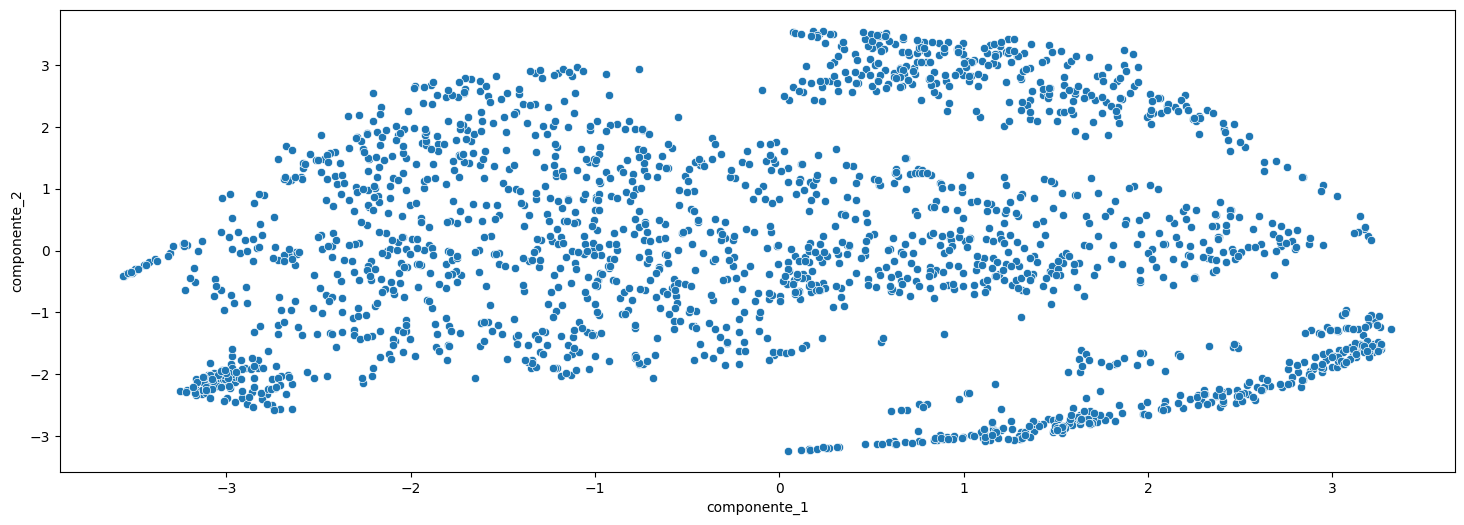

In [ ]:
sns.scatterplot(data = df_tsne, x = 'componente_1', y = 'componente_2')

Aqui, nota-se a existência de algumas regiões com maior densidade de pontos. Isso pode ser um indício da existência de grupos de pontos com características semelhantes. A seguir, partimos para a análise de agrupamento utilizando o algoritmo K-Means.

## Modelagem

In [ ]:
eqs = []
silhouette = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, n_init = 100, random_state=1)
  kmeans.fit(features_norm)
  eqs.append(kmeans.inertia_)
  if i > 1:
    silhouette.append(silhouette_score(features_norm, kmeans.labels_))

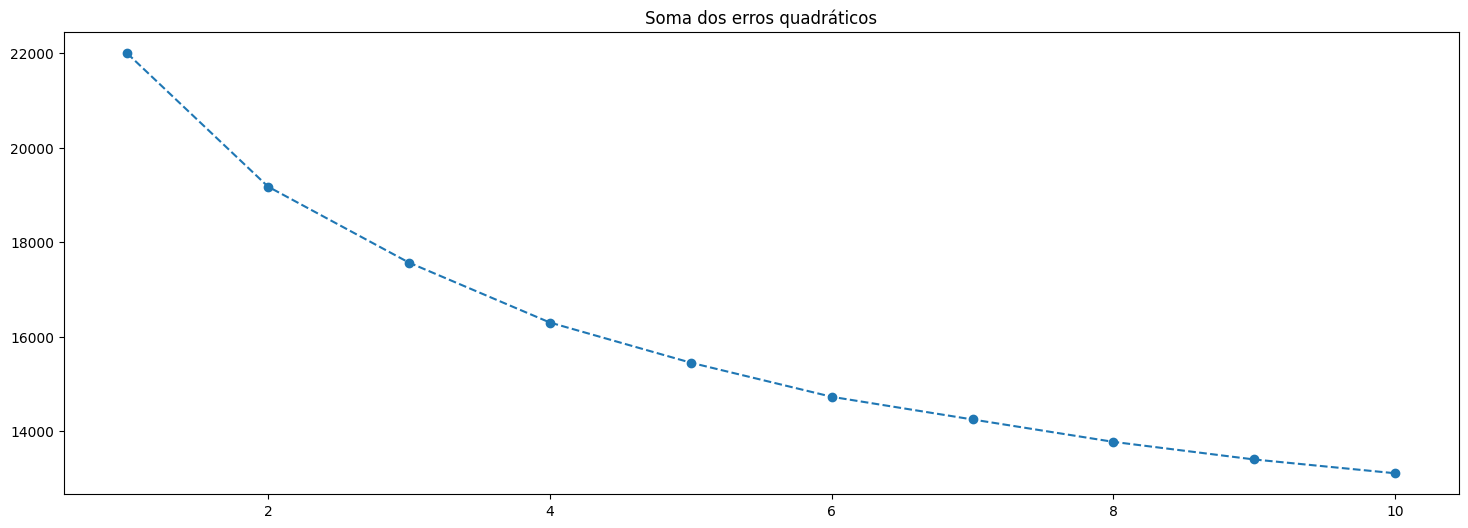

In [ ]:
plt.plot(range(1, 11), eqs, 'o', linestyle='--')
plt.title("Soma dos erros quadráticos")
plt.show()

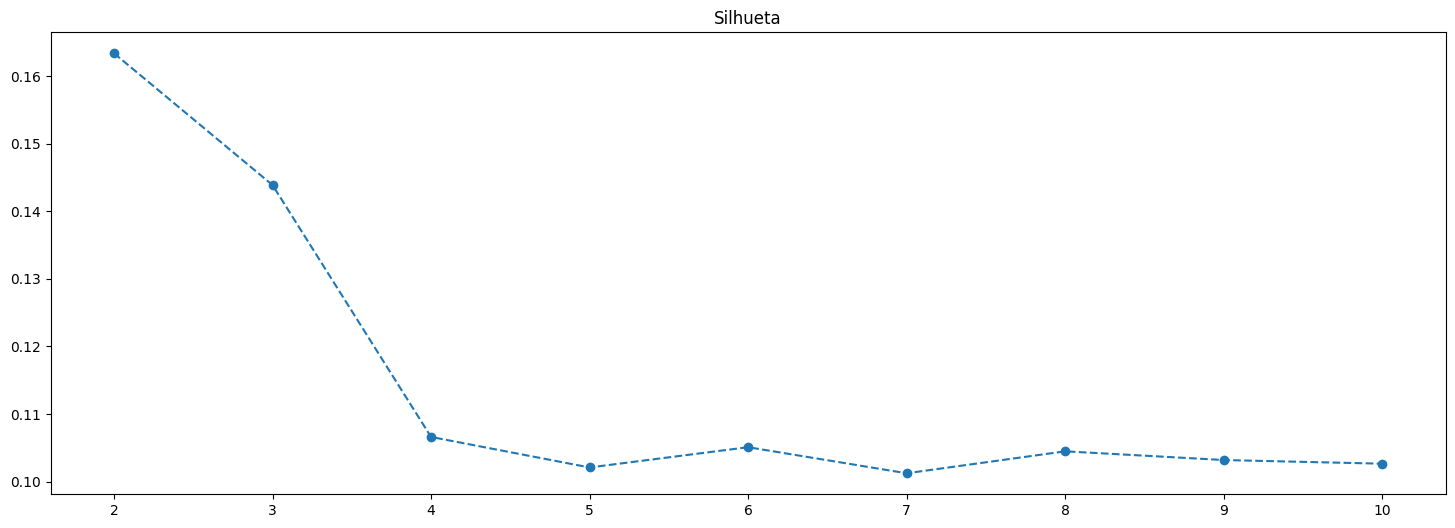

In [ ]:
plt.plot(range(2, 11), silhouette, 'o', linestyle='--')
plt.title("Silhueta")
plt.show()

Com base na análise dos gráficos e em testes realizados, define-se o número de grupos em 3. Então, observa-se os grupos definidos pelo k-means no gráfico resultante da aplicação do t-SNE:

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=100, random_state=1)
kmeans.fit(features_norm)
kmeans.labels_

array([2, 2, 1, ..., 2, 0, 2], dtype=int32)

In [ ]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 477,  358, 1165]))

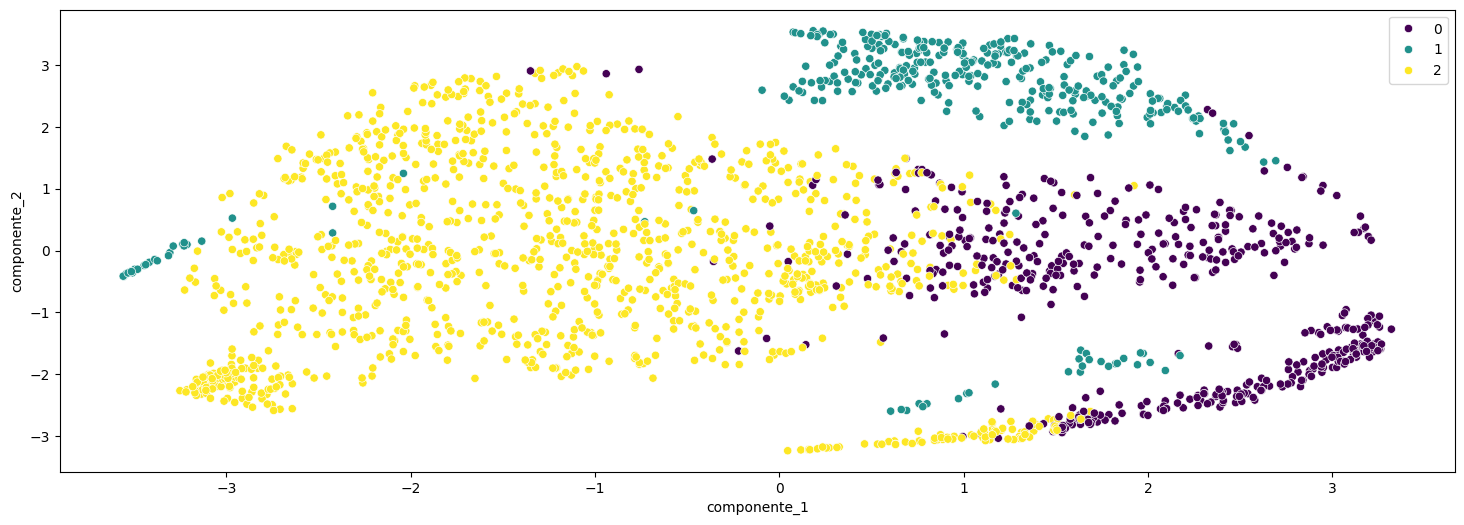

In [ ]:
sns.scatterplot(data = df_tsne, x = 'componente_1', y = 'componente_2', hue=kmeans.labels_, palette='viridis')
plt.show()

De fato, embora os grupos possuam alguns pontos de dados dispersos, a maior parte dos integrantes de cada grupo tende a concentrar-se em uma mesma região do espaço.

## Análise dos resultados e estatísticas por grupo

Partimos agora para a análise das características de cada grupo.

In [ ]:
def mostrarGrafico(coluna, titulo):
  plt.figure(figsize=(10, 5))
  total = features.groupby('clusters').count()[coluna].reset_index()
  variavel = features[features[coluna] == 1].groupby('clusters')[coluna].sum().reset_index()
  variavel[coluna] = [i / j * 100 for i,j in zip(variavel[coluna], total[coluna])]
  total[coluna] = [i / j * 100 for i,j in zip(total[coluna], total[coluna])]

  bar1 = sns.barplot(x="clusters",  y=coluna, data=total, color='#A16F8D')

  bar2 = sns.barplot(x="clusters", y=coluna, data=variavel, color='#2D223A')

  top_bar = mpatches.Patch(label='Não', color='#A16F8D')
  bottom_bar = mpatches.Patch(label='Sim', color='#2D223A')

  plt.title(titulo)
  plt.legend(handles=[top_bar, bottom_bar])

  plt.show()

Resumo das estatísticas por variável:

In [ ]:
cluster_labels = np.array([x + 1 for x in kmeans.labels_])
features['clusters'] = cluster_labels

In [ ]:
for col in features.columns.tolist():
  if col != 'clusters':
    print(f'{col}:')
    print(features.groupby(['clusters'])[col].describe().T)
    print(' ')

part_time_job:
clusters           1           2            3
count     477.000000  358.000000  1165.000000
mean        0.429769    0.081006     0.070386
std         0.495563    0.273226     0.255907
min         0.000000    0.000000     0.000000
25%         0.000000    0.000000     0.000000
50%         0.000000    0.000000     0.000000
75%         1.000000    0.000000     0.000000
max         1.000000    1.000000     1.000000
 
absence_days:
clusters           1           2            3
count     477.000000  358.000000  1165.000000
mean        5.909853    3.365922     2.838627
std         2.861334    2.322141     2.023416
min         0.000000    0.000000     0.000000
25%         4.000000    2.000000     1.000000
50%         6.000000    3.000000     2.000000
75%         8.000000    5.000000     4.000000
max        10.000000   10.000000    10.000000
 
extracurricular_activities:
clusters           1      2       3
count     477.000000  358.0  1165.0
mean        0.104822    1.0     0.0
std

### Trabalho de Meio Período

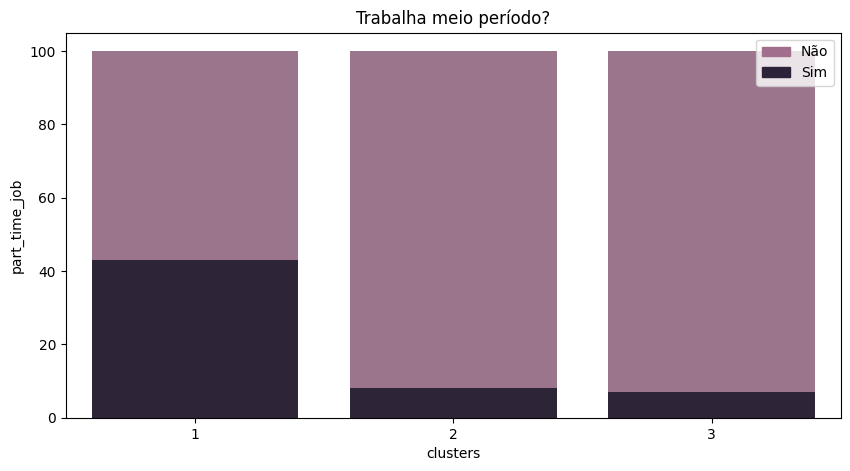

In [ ]:
mostrarGrafico('part_time_job', 'Trabalha meio período?')

Para essa variável, observa-se que o grupo 1 concentra a maior parte dos estudantes que trabalham meio período. Já nos demais grupos, esses estudantes são a minoria.

### Atividades Extracurriculares

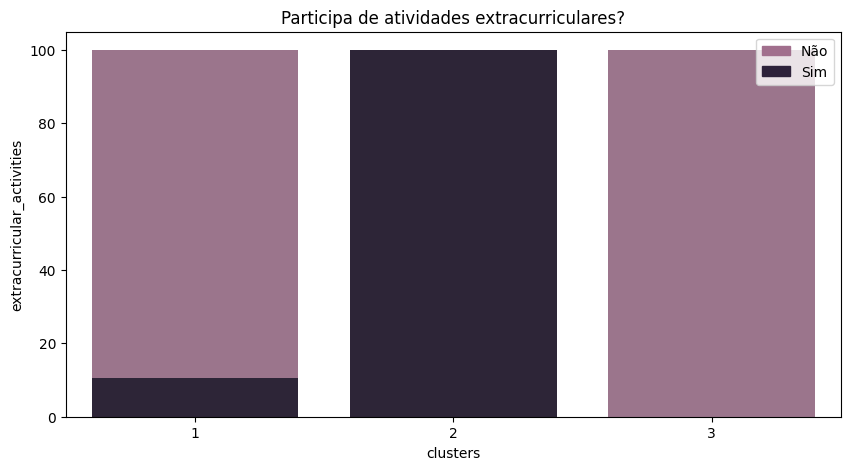

In [ ]:
mostrarGrafico('extracurricular_activities', 'Participa de atividades extracurriculares?')

Quanto às atividades extracurriculares, apenas uma pequena parcela dos estudantes do grupo 1 realiza esse tipo de atividade. No grupo 2, 100% dos estudantes estão envolvidos em alguma atividade extracurricular e, no grupo 3, 100% não participa de qualquer atividade dessa natureza.

### Notas e Tempo de Estudo

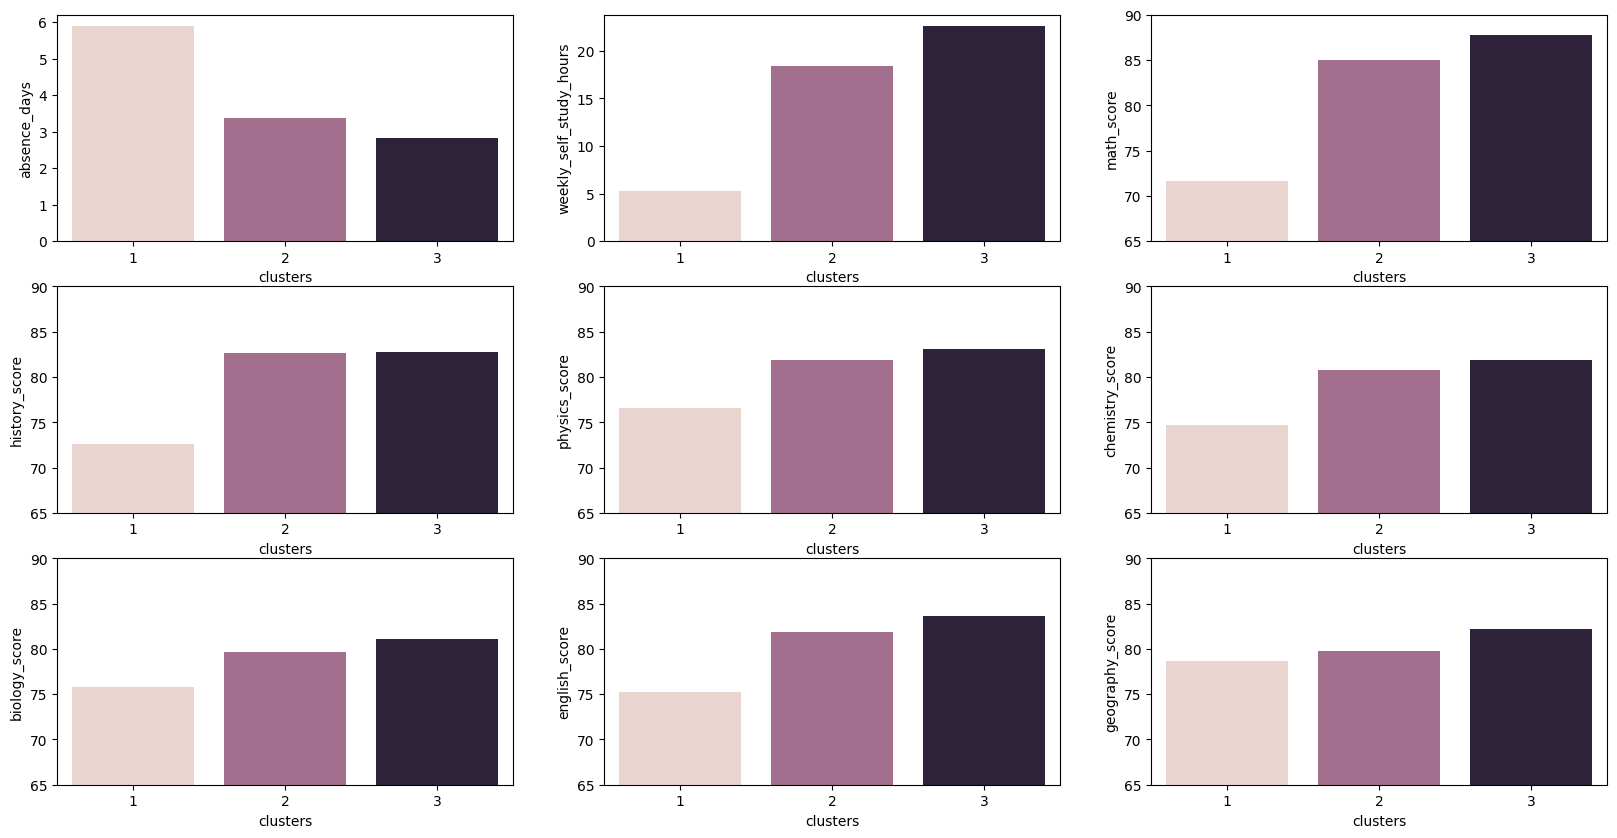

In [ ]:
columns = ['absence_days', 'weekly_self_study_hours', 'math_score', 'history_score',
       'physics_score', 'chemistry_score', 'biology_score', 'english_score',
       'geography_score']
figure, axis = plt.subplots(3, 3, figsize=(20, 10))
k = 0
for i in range(3):
  for j in range(3):
    if columns[k][-6:] == '_score':
      axis[i, j].set(ylim=(65, 90))
    sns.barplot(ax=axis[i, j], x="clusters", y=columns[k], data=features, hue='clusters', errorbar=None, legend=False)
    k += 1
plt.show()

**Grupo 1:**

Observa-se que, em média, os estudantes do grupo 1 têm mais faltas e um tempo consideravelmente menor de horas de estudo por semana em comparação com estudantes dos outros grupos. Em conformidade com essa tendência, esse grupo possui um desempenho relativamente menor em todas as disciplinas. Como visto anteriormente, aproximadamente metade dos estudantes desse grupo trabalham meio período e uma parcela realiza atividades extracurriculares. Logo, esses alunos possuem mais dificuldade em conciliar outras atividades com os estudos.

**Grupo 2:**

O grupo 2, no qual 100% dos alunos realizam atividades extracurriculares, possui um desempenho quase intermediário, porém muito mais próximo ao grupo 3 do que ao grupo 1. A dedicação dos estudantes desse grupo, em termos de tempo de estudo e dias sem falta, também é, em média, maior que a do grupo 1 e menor que do grupo 3.

**Grupo 3:**

Já no grupo 3, a menor parte dos estudantes possuem um emprego de meio período e nenhum deles realiza atividades extracurriculares. De fato, o tempo médio de estudo por semana desse grupo é consideravelmente maior que para os demais, o número de dias com faltas é menor e, além disso, as notas são maiores em todas as disciplinas.


## Aprendizado Supervisionado

Agora, treina-se um modelo para classificar os alunos de acordo com os grupos encontrados anteriormente.

In [ ]:
features.head()

,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score,clusters
0,0,3,0,27,73,81,93,97,63,80,87,3
1,0,2,0,47,90,86,96,100,90,88,90,3
2,0,9,1,13,81,97,95,96,65,77,94,2
3,0,5,0,3,71,74,88,80,89,63,86,1
4,0,5,0,10,84,77,65,65,80,74,76,1


Separando features e target:

In [ ]:
X = features.drop('clusters', axis=1)
X.head()

,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,0,3,0,27,73,81,93,97,63,80,87
1,0,2,0,47,90,86,96,100,90,88,90
2,0,9,1,13,81,97,95,96,65,77,94
3,0,5,0,3,71,74,88,80,89,63,86
4,0,5,0,10,84,77,65,65,80,74,76


In [ ]:
y = features.clusters
y

0       3
1       3
2       2
3       1
4       1
       ..
1995    3
1996    3
1997    3
1998    1
1999    3
Name: clusters, Length: 2000, dtype: int64

Dividindo o dataset em treino e teste:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Realizando o ajuste de parâmetros:

In [ ]:
skf = StratifiedKFold(5)
folds = skf.split(X_train, y_train)
folds_list = list(folds)

In [ ]:
rf_params = {'model__n_estimators': [100, 200],
             'model__max_depth': [10, 20, None],
             'model__min_samples_leaf': [1, 5, 15, 20]}

rf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                            ('model', RandomForestClassifier())])

rf_search = GridSearchCV(rf_pipe, rf_params, cv = folds_list, scoring='accuracy', n_jobs=-1)

rf_search.fit(X_train, y_train)
print(rf_search.best_score_)
print(rf_search.best_params_)

0.9412500000000001
{'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}


Treinando o modelo:

In [ ]:
rf = rf_search.best_estimator_
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Analisando os resultados:

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.87      0.91       105
           2       0.97      1.00      0.99        78
           3       0.95      0.98      0.96       217

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [ ]:
cross_val_score(rf, X_train, y_train, cv=folds_list)

array([0.940625, 0.934375, 0.9375  , 0.946875, 0.95    ])

<Figure size 1000x1000 with 0 Axes>

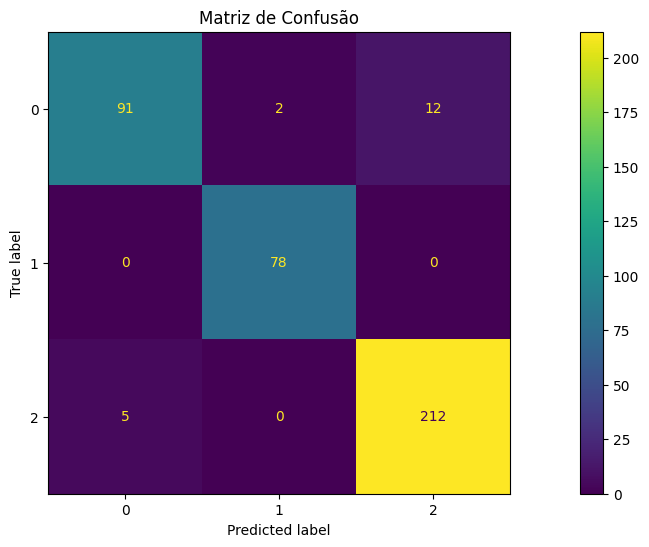

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(confusion_matrix = cm)

plt.figure(figsize=(10, 10))
cd.plot()
plt.title("Matriz de Confusão")
plt.show()

Verifica-se um ótimo desempenho do modelo em diferenciar os três grupos, já que as métricas de treino e teste estão satisfatórias e não há indício de overfitting.